# ETL Pipeline using Spark to Model US Immigration Data

#### Project Summary
The aim of this project is to create an ETL pipeline by reading in 3 sources sources of data  (the US I94 immigration data, U.S. city demographics data and temperature data) to create a STAR schema data model (dimension and fact tables) to allow for easier analysis of the immigration data. This data model will allow for various analyses to be carried out and will help to spot trends in the US immigration data, such as the most popular cities for immigration,the gender distribution of immigrants, the average age of immigrants etc.

The project follows the follow steps:
* Step 1: Scope the Project and Gather Data
* Step 2: Explore and Assess the Data
* Step 3: Define the Data Model
* Step 4: Run ETL to Model the Data
* Step 5: Complete Project Write Up

In [1]:
# Do all imports and installs here
import pandas as pd
from datetime import datetime, timedelta
from pyspark.sql import SparkSession
from pyspark.sql.functions import udf, year, month, col, round, dayofweek, weekofyear, dayofmonth
from pyspark.sql.types import StringType
import re

In [2]:
# Create Spark session
spark = SparkSession.builder.\
config("spark.jars.repositories", "https://repos.spark-packages.org/").\
config("spark.jars.packages", "saurfang:spark-sas7bdat:2.0.0-s_2.11").\
enableHiveSupport().getOrCreate()

### Step 1: Scope the Project and Gather Data

#### Scope 
The aim of this project is to create an ETL pipeline by reading in 3 sources sources of data  (the US I94 immigration data, U.S. city demographics data and temperature data) to create a STAR schema data model (dimension and fact tables) which can then be used for analysis.

#### Gatering the Data:
1. I94 Immigration Data - This dataset contains immigration data from the US National Tourism and Trade Office. The I-94 is the Arrival/Departure Record, in either paper or electronic format, issued by a Customs and Border Protection (CBP) Officer to foreign visitors entering the United States. For this project we will be working with data from April 2016.
2. World Temperature Data - This dataset came from Kaggle, and contains data on the average temperature of cities.
3. U.S. City Demographic Data - This data comes from OpenSoft, and contains data on the demographics of US Cities such as gender, race, age etc.

In [3]:
# Read in immigration data
fname = '../../data/18-83510-I94-Data-2016/i94_apr16_sub.sas7bdat'
df_immigration = spark.read.format('com.github.saurfang.sas.spark').load(fname)


In [4]:
# Read in temperature data
fname = "../../data2/GlobalLandTemperaturesByCity.csv"
df_temperature = spark.read.format("csv").option("delimiter", ",").option("header", "true").load(fname)

In [5]:
# Read in demographics data
fname = "us-cities-demographics.csv"
df_demo = spark.read.format("csv").option("delimiter", ";").option("header", "true").load(fname)

In [6]:



#df_spark = spark.read.format('com.github.saurfang.sas.spark').load('../../data/18-83510-I94-Data-2016/i94_apr16_sub.sas7bdat')


In [7]:
#write to parquet
#df_spark.write.parquet("sas_data")
#df_spark=spark.read.parquet("sas_data")

### Step 2: Explore, Assess and Clean the Data
#### Immigration Data


In [8]:
df_immigration.show(10)

+-----+------+------+------+------+-------+-------+-------+-------+-------+------+-------+-----+--------+--------+-----+-------+-------+-------+-------+-------+--------+------+------+-------+--------------+-----+--------+
|cicid| i94yr|i94mon|i94cit|i94res|i94port|arrdate|i94mode|i94addr|depdate|i94bir|i94visa|count|dtadfile|visapost|occup|entdepa|entdepd|entdepu|matflag|biryear| dtaddto|gender|insnum|airline|        admnum|fltno|visatype|
+-----+------+------+------+------+-------+-------+-------+-------+-------+------+-------+-----+--------+--------+-----+-------+-------+-------+-------+-------+--------+------+------+-------+--------------+-----+--------+
|  6.0|2016.0|   4.0| 692.0| 692.0|    XXX|20573.0|   null|   null|   null|  37.0|    2.0|  1.0|    null|    null| null|      T|   null|      U|   null| 1979.0|10282016|  null|  null|   null| 1.897628485E9| null|      B2|
|  7.0|2016.0|   4.0| 254.0| 276.0|    ATL|20551.0|    1.0|     AL|   null|  25.0|    3.0|  1.0|20130811|     SE

In [9]:
df_immigration.count()

3096313

In [10]:
df_immigration.printSchema()

root
 |-- cicid: double (nullable = true)
 |-- i94yr: double (nullable = true)
 |-- i94mon: double (nullable = true)
 |-- i94cit: double (nullable = true)
 |-- i94res: double (nullable = true)
 |-- i94port: string (nullable = true)
 |-- arrdate: double (nullable = true)
 |-- i94mode: double (nullable = true)
 |-- i94addr: string (nullable = true)
 |-- depdate: double (nullable = true)
 |-- i94bir: double (nullable = true)
 |-- i94visa: double (nullable = true)
 |-- count: double (nullable = true)
 |-- dtadfile: string (nullable = true)
 |-- visapost: string (nullable = true)
 |-- occup: string (nullable = true)
 |-- entdepa: string (nullable = true)
 |-- entdepd: string (nullable = true)
 |-- entdepu: string (nullable = true)
 |-- matflag: string (nullable = true)
 |-- biryear: double (nullable = true)
 |-- dtaddto: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- insnum: string (nullable = true)
 |-- airline: string (nullable = true)
 |-- admnum: double (nullable = 

In [11]:
df_immigration.createOrReplaceTempView("tblImmigration")

In [12]:
# check cicd can be used as primary key
spark.sql("""
SELECT COUNT (DISTINCT cicid)
FROM tblImmigration
""").show()

+---------------------+
|count(DISTINCT cicid)|
+---------------------+
|              3096313|
+---------------------+



In [13]:
# Remove any duplicates
df_immigration_clean = df_immigration.drop_duplicates()

In [14]:
# All dates in SAS correspond to the number of days since 1960-01-01. 
# Create udf to convert SAS date value to date 
@udf(StringType())
def convert_to_date(x):
    if x:
        return ((datetime(1960, 1, 1).date() + timedelta(x))).isoformat()
    return None

In [15]:
# convert SAS date to date 
df_immigration_clean = df_immigration_clean.withColumn("arrdate", convert_to_date(df_immigration_clean.arrdate))
df_immigration_clean = df_immigration_clean.withColumn("depdate", convert_to_date(df_immigration_clean.depdate))

#### Temperature Data


In [16]:
df_temperature.show(5)

+----------+------------------+-----------------------------+-----+-------+--------+---------+
|        dt|AverageTemperature|AverageTemperatureUncertainty| City|Country|Latitude|Longitude|
+----------+------------------+-----------------------------+-----+-------+--------+---------+
|1743-11-01|             6.068|           1.7369999999999999|Århus|Denmark|  57.05N|   10.33E|
|1743-12-01|              null|                         null|Århus|Denmark|  57.05N|   10.33E|
|1744-01-01|              null|                         null|Århus|Denmark|  57.05N|   10.33E|
|1744-02-01|              null|                         null|Århus|Denmark|  57.05N|   10.33E|
|1744-03-01|              null|                         null|Århus|Denmark|  57.05N|   10.33E|
+----------+------------------+-----------------------------+-----+-------+--------+---------+
only showing top 5 rows



In [17]:
df_temperature.createOrReplaceTempView("tblTemperature")

# check number of countries present in temperature dataset
spark.sql("""
SELECT COUNT (DISTINCT Country)
FROM tblTemperature
""").show()

+-----------------------+
|count(DISTINCT Country)|
+-----------------------+
|                    159|
+-----------------------+



In [18]:
# keep only U.S. data
df_temperature_clean = df_temperature.where(df_temperature.Country == 'United States')

In [19]:
df_temperature_clean.show(5)

+----------+------------------+-----------------------------+-------+-------------+--------+---------+
|        dt|AverageTemperature|AverageTemperatureUncertainty|   City|      Country|Latitude|Longitude|
+----------+------------------+-----------------------------+-------+-------------+--------+---------+
|1820-01-01|2.1010000000000004|                        3.217|Abilene|United States|  32.95N|  100.53W|
|1820-02-01|             6.926|                        2.853|Abilene|United States|  32.95N|  100.53W|
|1820-03-01|            10.767|                        2.395|Abilene|United States|  32.95N|  100.53W|
|1820-04-01|17.988999999999994|                        2.202|Abilene|United States|  32.95N|  100.53W|
|1820-05-01|            21.809|                        2.036|Abilene|United States|  32.95N|  100.53W|
+----------+------------------+-----------------------------+-------+-------------+--------+---------+
only showing top 5 rows



In [20]:
df_temperature_clean.printSchema()

root
 |-- dt: string (nullable = true)
 |-- AverageTemperature: string (nullable = true)
 |-- AverageTemperatureUncertainty: string (nullable = true)
 |-- City: string (nullable = true)
 |-- Country: string (nullable = true)
 |-- Latitude: string (nullable = true)
 |-- Longitude: string (nullable = true)



In [21]:
# drop any columns with missing average temperature value
df_temperature_clean = df_temperature_clean.dropna(how="any", subset=["AverageTemperature"])

In [22]:
# Create dictionary of city codes: city name
i94_sas_label_descriptions_fname = "I94_SAS_Labels_Descriptions.SAS"
with open(i94_sas_label_descriptions_fname) as f:
    lines = f.readlines()

pattern_object = re.compile(r"\'(.*)\'.*\'(.*)\'")
city_dict = {}
for line in lines[302:961]:
    city_code_map = pattern_object.search(line)
    city_dict[city_code_map.group(1)] = city_code_map.group(2).rstrip()

In [23]:
# function to determine city code from city name
@udf(StringType())
def city_to_city_code(city):
    for key in city_dict:
        if city.lower() in city_dict[key].lower():
            return key

In [24]:
# map city codes and drop any blanks
df_temperature_clean = df_temperature_clean.withColumn("city_code", city_to_city_code(df_temperature_clean["City"]))
df_temperature_clean = df_temperature_clean.dropna(how='any', subset=["city_code"])

# correct data types
df_temperature_clean = df_temperature_clean.withColumn("AverageTemperature", col("AverageTemperature").cast("float")) 
df_temperature_clean = df_temperature_clean.withColumn("AverageTemperatureUncertainty", col("AverageTemperatureUncertainty").cast("float")) 

# add year and month columns
df_temperature_clean = df_temperature_clean.withColumn("year", year(df_temperature_clean['dt'])) \
                        .withColumn("month", month(df_temperature_clean["dt"]))
 



In [25]:
df_temperature_clean.show(5)

+----------+------------------+-----------------------------+-----+-------------+--------+---------+---------+----+-----+
|        dt|AverageTemperature|AverageTemperatureUncertainty| City|      Country|Latitude|Longitude|city_code|year|month|
+----------+------------------+-----------------------------+-----+-------------+--------+---------+---------+----+-----+
|1743-11-01|             3.209|                        1.961|Akron|United States|  40.99N|   80.95W|      AKR|1743|   11|
|1744-04-01|            10.352|                        2.222|Akron|United States|  40.99N|   80.95W|      AKR|1744|    4|
|1744-05-01|            15.487|                        1.867|Akron|United States|  40.99N|   80.95W|      AKR|1744|    5|
|1744-06-01|              20.9|                        1.726|Akron|United States|  40.99N|   80.95W|      AKR|1744|    6|
|1744-07-01|            22.111|                        1.529|Akron|United States|  40.99N|   80.95W|      AKR|1744|    7|
+----------+------------

#### US City Demographics Data

In [26]:
df_demo.show(5)

+----------------+-------------+----------+---------------+-----------------+----------------+------------------+------------+----------------------+----------+--------------------+-----+
|            City|        State|Median Age|Male Population|Female Population|Total Population|Number of Veterans|Foreign-born|Average Household Size|State Code|                Race|Count|
+----------------+-------------+----------+---------------+-----------------+----------------+------------------+------------+----------------------+----------+--------------------+-----+
|   Silver Spring|     Maryland|      33.8|          40601|            41862|           82463|              1562|       30908|                   2.6|        MD|  Hispanic or Latino|25924|
|          Quincy|Massachusetts|      41.0|          44129|            49500|           93629|              4147|       32935|                  2.39|        MA|               White|58723|
|          Hoover|      Alabama|      38.5|          38040| 

In [27]:
df_demo.select('Race').distinct().show(truncate=False)

+---------------------------------+
|Race                             |
+---------------------------------+
|Black or African-American        |
|Hispanic or Latino               |
|White                            |
|Asian                            |
|American Indian and Alaska Native|
+---------------------------------+



In [28]:
df_demo.count()

2891

In [29]:
df_demo.where(df_demo['City']=='Oakland').show()
# based on this output the race count can be split out into seperate columns

+-------+----------+----------+---------------+-----------------+----------------+------------------+------------+----------------------+----------+--------------------+------+
|   City|     State|Median Age|Male Population|Female Population|Total Population|Number of Veterans|Foreign-born|Average Household Size|State Code|                Race| Count|
+-------+----------+----------+---------------+-----------------+----------------+------------------+------------+----------------------+----------+--------------------+------+
|Oakland|California|      35.7|         203827|           215451|          419278|             12159|      113896|                  2.56|        CA|Black or African-...|118228|
|Oakland|California|      35.7|         203827|           215451|          419278|             12159|      113896|                  2.56|        CA|  Hispanic or Latino|114054|
|Oakland|California|      35.7|         203827|           215451|          419278|             12159|      113896| 

In [30]:
df_demo.printSchema()

root
 |-- City: string (nullable = true)
 |-- State: string (nullable = true)
 |-- Median Age: string (nullable = true)
 |-- Male Population: string (nullable = true)
 |-- Female Population: string (nullable = true)
 |-- Total Population: string (nullable = true)
 |-- Number of Veterans: string (nullable = true)
 |-- Foreign-born: string (nullable = true)
 |-- Average Household Size: string (nullable = true)
 |-- State Code: string (nullable = true)
 |-- Race: string (nullable = true)
 |-- Count: string (nullable = true)



In [31]:
# map city codes and drop any blanks
df_demo_clean = df_demo.withColumn("city_code", city_to_city_code(df_demo["City"]))
df_demo_clean = df_demo_clean.dropna(how='any', subset=["city_code"])

In [32]:
# correct data types - convert strings to long or float values
df_demo_clean = df_demo_clean.withColumn("Count", col("Count").cast("long")) 
df_demo_clean = df_demo_clean.withColumn("Median Age", col("Median Age").cast("float")) 
df_demo_clean = df_demo_clean.withColumn("Male Population", col("Male Population").cast("long")) 
df_demo_clean = df_demo_clean.withColumn("Female Population", col("Female Population").cast("long")) 
df_demo_clean = df_demo_clean.withColumn("Number of Veterans", col("Number of Veterans").cast("long")) 
df_demo_clean = df_demo_clean.withColumn("Total Population", col("Total Population").cast("long")) 
df_demo_clean = df_demo_clean.withColumn("Foreign-born", col("Foreign-born").cast("long")) 
df_demo_clean = df_demo_clean.withColumn("Average Household Size", col("Average Household Size").cast("float")) 

In [33]:
df_demo_clean = df_demo_clean.groupBy(['City','city_code','State', 'State Code','Median Age','Male Population','Female Population','Total Population','Number of Veterans','Foreign-born','Average Household Size']).pivot('Race').sum('Count')

In [34]:
# check string values have been converted properly
df_demo_clean.printSchema()

root
 |-- City: string (nullable = true)
 |-- city_code: string (nullable = true)
 |-- State: string (nullable = true)
 |-- State Code: string (nullable = true)
 |-- Median Age: float (nullable = true)
 |-- Male Population: long (nullable = true)
 |-- Female Population: long (nullable = true)
 |-- Total Population: long (nullable = true)
 |-- Number of Veterans: long (nullable = true)
 |-- Foreign-born: long (nullable = true)
 |-- Average Household Size: float (nullable = true)
 |-- American Indian and Alaska Native: long (nullable = true)
 |-- Asian: long (nullable = true)
 |-- Black or African-American: long (nullable = true)
 |-- Hispanic or Latino: long (nullable = true)
 |-- White: long (nullable = true)



In [35]:
# check race has been correcly split out into columns
df_demo_clean.where(df_demo_clean['City']=='Oakland').show()

+-------+---------+----------+----------+----------+---------------+-----------------+----------------+------------------+------------+----------------------+---------------------------------+-----+-------------------------+------------------+------+
|   City|city_code|     State|State Code|Median Age|Male Population|Female Population|Total Population|Number of Veterans|Foreign-born|Average Household Size|American Indian and Alaska Native|Asian|Black or African-American|Hispanic or Latino| White|
+-------+---------+----------+----------+----------+---------------+-----------------+----------------+------------------+------------+----------------------+---------------------------------+-----+-------------------------+------------------+------+
|Oakland|      OAK|California|        CA|      35.7|         203827|           215451|          419278|             12159|      113896|                  2.56|                             8380|75446|                   118228|            114054|1715

### Step 3: Define the Data Model
#### 3.1 Conceptual Data Model


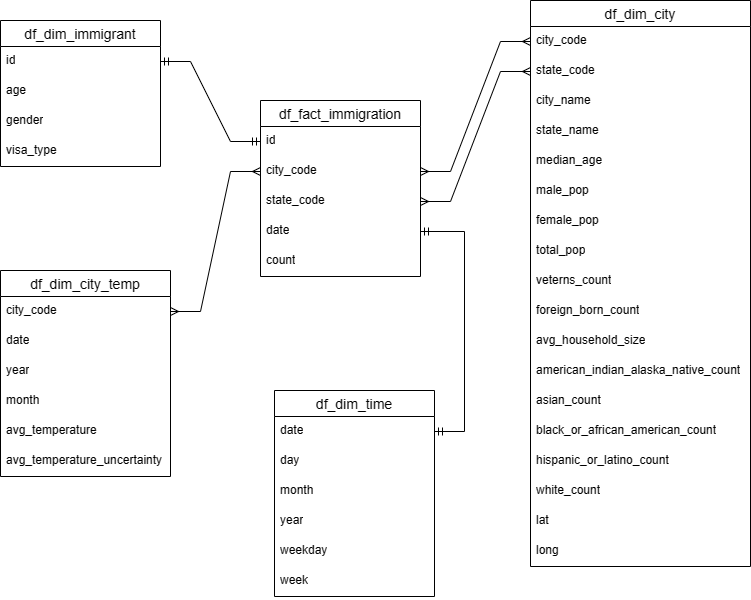

In [67]:
from IPython.display import Image
Image(filename='ERD.png') 

#### Staging Tables
df_staging_immigration
   - id
   - date
   - city_code
   - state_code
   - age
   - gender
   - visa_type
   - count
    
df_staging_temperature
   - year
   - month
   - city_code
   - city_name
   - avg_temperature
   - avg_temperature_uncertainty
   - lat
   - long
    
df_staging_demographics
   - city_code
   - state_code
   - city_name
   - median_age
   - male_pop
   - female_pop
   - total_pop
   - veterans_count
   - foreign_born_count
   - avg_household_size
   - american_indian_alaska_native_count
   - asian_count
   - black_or_african_american_count
   - hispanic_or_latino_count
   - white_count


#### Dimension Tables
df_immigrant
   - id
   - age
   - gender
   - visa_type
    
df_city
   - city_code
   - state_code
   - city_name
   - state_name
   - median_age
   - male_pop
   - female_pop
   - total_pop
   - veterans_count
   - foreign_born_count
   - avg_household_size
   - american_indian_alaska_native_count
   - asian_count
   - black_or_african_american_count
   - hispanic_or_latino_count
   - white_count
   - lat
   - long
    
    
df_city_temp
   - city_code
   - year
   - month
   - avg_temperature
   - avg_temperature_uncertainty
    
df_time
  - date
  - dayofweek
  - weekofyear
  - month

#### Fact Table
df_immigration
   - id
   - state_code
   - city_code
   - date
   - count

#### 3.2 Mapping Out Data Pipelines
##### Steps necessary to pipeline the data into the data model
1. Clean data sources
2. Load staging tables
3. Create dimension and fact tables
4. Save dimension and fact tables into parquet files which can then be used for analsyis

### Step 4: Run Pipelines to Model the Data 
#### 4.1 Create the data model
Build the data pipelines to create the data model.

##### Load Staging Tables

In [36]:
df_staging_immigration = df_immigration_clean.select(
                            col("cicid").alias("id"),
                            col("arrdate").alias("date"),
                            col("i94port").alias("city_code"),
                            col("i94addr").alias("state_code"),
                            col("i94bir").alias("age"),
                            col("gender"),
                            col("i94visa").alias("visa_type"),
                            col("count")
                            ).drop_duplicates()

In [37]:
df_staging_temperature = df_temperature_clean.select(
                                        col('dt').alias("date"),
                                        col("year"), 
                                        col("month"), 
                                        col("city_code"),
                                        col("City").alias("city_name"),
                                        round(col("AverageTemperature"), 2).alias("avg_temperature"),
                                        round(col("AverageTemperatureUncertainty"), 2).alias("avg_temperature_uncertainty"),
                                        col("Latitude").alias("lat"), 
                                        col("Longitude").alias("long")
                                        ).drop_duplicates()

In [38]:
df_staging_demographics = df_demo_clean.select(
                                        col("City").alias("city_name"),
                                        col("city_code"),
                                        col("state").alias("state_name"),
                                        col("State Code").alias("state_code"),
                                        round(col("Median Age"), 2).alias("median_age"),
                                        col("Male Population").alias("male_pop"), 
                                        col("Female Population").alias("female_pop"),
                                        col("Total Population").alias("total_pop"),
                                        col("Number of Veterans").alias("veterans_count"),
                                        col("Foreign-born").alias("foreign_born_count"),
                                        round(col("Average Household Size"),2).alias("avg_household_size"),
                                        col("American Indian and Alaska Native").alias("american_indian_alaska_native_count"),
                                        col("Asian").alias("asian_count"),
                                        col("Black or African-American").alias("black_or_african_american_count"),
                                        col("Hispanic or Latino").alias("hispanic_or_latino_count"),
                                        col("White").alias("white_count"),
                                        ).drop_duplicates()

##### Create dimension and Fact Tables

In [39]:
df_immigrant = df_staging_immigration.select("id", "age", "gender", "visa_type")

In [40]:
df_city = df_staging_demographics.join(df_staging_temperature, "city_code").select(
                                    "city_code", "state_code", df_staging_demographics["city_name"],
                                    "state_name",
                                    "median_age","male_pop",
                                    "female_pop","total_pop",
                                    "veterans_count","foreign_born_count"
                                    ,"avg_household_size","american_indian_alaska_native_count",
                                    "asian_count", "black_or_african_american_count",
                                    "hispanic_or_latino_count",
                                    "white_count","lat","long").drop_duplicates()

In [41]:
df_city_temp = df_staging_temperature.select("date","city_code", "year", "month",
                                             "avg_temperature","avg_temperature_uncertainty").drop_duplicates()

In [42]:
df_time = df_staging_immigration.withColumn("weekday", dayofweek("date"))\
                .withColumn("day", dayofmonth("date"))\
                .withColumn("week", weekofyear("date"))\
                .withColumn("month", month("date"))\
                .withColumn("year", year("date"))
    
    
df_time = df_time.select("date", "day", "month", "year", "weekday", "week").drop_duplicates()

In [43]:
df_immigration = df_staging_immigration.select("id", "state_code", "city_code", "date", "count").drop_duplicates()

##### Save tables into parquet files

In [ ]:
df_immigrant.write.mode("overwrite").partitionBy("gender", "age").parquet("immigrant")

df_city.write.mode("overwrite").partitionBy("state_code").parquet("city")

df_city_temp.write.mode("overwrite").parquet("city_temperatue")

df_time.write.mode("overwrite").parquet("time")

df_immigration.write.mode("overwrite").partitionBy("state_code", "city_code").parquet("immigration")

#### 4.2 Data Quality Checks
 
Run Quality Checks

In [44]:
# Check Tables exist
def table_exists(df, df_name):
    try:
        if df is not None:
            print(f"Table existance check passed. {df_name} found!")
            return 1
        else:
            print(f"Table existance check failed. {df_name} could not be found!")
            return 0
        
    except Exception as e:
        
        print((f"Table existance check failed for {df_name}. Error occurred during check: {e}"))
        return 0

In [45]:
# Check number of records in tables
def records_found(df, df_name):
    
    try:
        
        record_count = df.count()
    
        if record_count == 0:
            print(f"Record check failed for {df_name}. No records found!")
            return 0
        else:
            print (f"Record check passed for {df_name}. {record_count} records found!")
            return 1
    
    except Exception as e:
        
        print((f"Record check failed for {df_name}. Error occurred during check: {e}"))
        return 0


In [46]:
# Run checks
dfs_dict = {"df_immigrant": df_immigrant,
            "df_city": df_city, 
            "df_city_temp": df_city_temp, 
            "df_time": df_time, 
            "df_immigration": df_immigration}

def run_checks(dfs_dict):
    result = 0
    total = 0
    for df_name, df in dfs_dict.items():
        result += table_exists(df, df_name) + records_found(df, df_name)
        total  += 2
    
    if result == total:
        msg = f"Checks complete. {result}/{total} checks passed. All checks passed!"
    else:
        msg = f"Checks complete. {result}/{total} checks passed. {total-result} checks failed!"
    return msg

print(run_checks(dfs_dict))

    


Table existance check passed. df_immigrant found!
Record check passed for df_immigrant. 3096313 records found!
Table existance check passed. df_city found!
Record check passed for df_city. 142 records found!
Table existance check passed. df_city_temp found!
Record check passed for df_city_temp. 313024 records found!
Table existance check passed. df_time found!
Record check passed for df_time. 30 records found!
Table existance check passed. df_immigration found!
Record check passed for df_immigration. 3096313 records found!
Checks complete. 10/10 checks passed. All checks passed!


#### 4.3 Data dictionary 
A brief description of what the data is


#### Dimension Tables
df_immigrant
   - id: id of immigrant
   - age : age of immigrant
   - gender: gender of immigrant
   - visa_type : immigrant's visa type
    
df_city
   - city_code: city port code
   - state_code: state code of city
   - city_name: name of city
   - state_name: name of state
   - median_age: median age of city's population
   - male_pop: number of males in city
   - female_pop: number of females in city
   - total_pop: total population of city
   - veterans_count: number of veterens in city
   - foreign_born_count: number of people in city born in a foreign country
   - avg_household_size: average size of houshold in city
   - american_indian_alaska_native_count: number of American Indian and Alaskan Natives in city
   - asian_count: number of Asians in city
   - black_or_african_american_count: number of Black or African Americans in city
   - hispanic_or_latino_count: number of hispanics or latinos in city
   - white_count: number of white people in city
   - lat: latitude of city
   - long: longitude of city
    
    
df_city_temp
   - city_code: city port code
   - date
   - year
   - month
   - avg_temperature: average temperature in city for particular month
   - avg_temperature_uncertainty: average temperature uncertainty in city for particular month
    
df_time
  - date
  - day
  - month
  - year
  - weekday
  - week
  
#### Fact Table
df_immigration
   - id: unique number 
   - state_code: state code of arrival city
   - city_code: city port code of arrival city
   - date: date of arrival
   - count: used for summary statistics, always 1

#### Step 5: Complete Project Write Up
* Clearly state the rationale for the choice of tools and technologies for the project.
    - Apache spark was used for this project because of it's ability to handle multiple file formats with large amounts of data. Furthermore, spark can quickly perform processing tasks on very large data sets and has an easy-to-use API. 
* Propose how often the data should be updated and why.
    - As the I94 immigration data is updated monthly, the other relevant datasets should also be updated monthly. 
* Write a description of how you would approach the problem differently under the following scenarios:
 * The data was increased by 100x.
     - If the data was increased by 100x I would consider running Spark in the cloud rather than in local mode. Running Spark across a spark cluster on Amazon EMR would allow for much faster processing. Moreover, rather than loading the data into parquet files, I would load the data into a relational database which would allow for more convenient querying and analysis of the data.
 * The data populates a dashboard that must be updated on a daily basis by 7am every day.
     -  If this was the case I would use Apache Airflow to manage the ETL pipeline. This would allow for the data pipeline job to be scheduled and automated which would ensure that the pipeline runs on tim. Airflow also provides a convenient way of monitoring the ETL pipeline job.
 * The database needed to be accessed by 100+ people.
     - I would use a cloud database solution to store the data (e.g. Amazon Redshift), as this is easily scalable (both horizontally and vertically, with autoscaling available) and a load balancer can be used to help manage traffic, which would ensure that the data can be accessed by a large volume of people at once, while maintaining fast performance.

## Sample Queries on final data model (after running etl.py)

In [2]:
# Create Spark session
spark = SparkSession.builder.\
config("spark.jars.repositories", "https://repos.spark-packages.org/").\
config("spark.jars.packages", "saurfang:spark-sas7bdat:2.0.0-s_2.11").\
enableHiveSupport().getOrCreate()

In [4]:
# load dim and fact tables saved parquet output files
df_dim_immigrant = spark.read.parquet('output/immigrant')
df_dim_city = spark.read.parquet('output/city')
df_dim_city_temp = spark.read.parquet('output/city_temperature')
df_dim_time = spark.read.parquet('output/time')
df_fact_immigration = spark.read.parquet('output/immigration')


It might be interesting to see if immigrants tend to go to cities where there are more foreign born people. To check this lets carry out some analysis:

In [42]:
# join df_fact_immigration with df_dim_city
df_join = df_fact_immigration.join(df_dim_city, 
                             (df_fact_immigration.city_code == df_dim_city.city_code) & 
                             (df_fact_immigration.state_code == df_dim_city.state_code))

In [43]:
# return only columns we want to keep
df = df_join.select('id',"city_name", df_fact_immigration["state_code"], 
        'foreign_born_count','total_pop')\
        .withColumn("foreign_born_pct", (df['foreign_born_count']/df['total_pop']) * 100)

df.show()

+---------+-------------+----------+------------------+---------+------------------+
|       id|    city_name|state_code|foreign_born_count|total_pop|  foreign_born_pct|
+---------+-------------+----------+------------------+---------+------------------+
|  21853.0|     New York|        NY|           3212500|  8550405| 37.57131972111263|
| 243533.0|  Los Angeles|        CA|           1485425|  3971896|37.398386060460794|
| 445543.0|       Boston|        MA|            190123|   669469| 28.39907449037969|
| 450428.0|      Atlanta|        GA|             32016|   463875| 6.901859337105902|
| 629341.0|      Orlando|        FL|             50558|   270917| 18.66180416880447|
| 632051.0|      Houston|        TX|            696210|  2298628| 30.28806749069445|
| 647895.0|        Miami|        FL|            260789|   440989|  59.1373027445129|
| 660401.0|     New York|        NY|           3212500|  8550405| 37.57131972111263|
| 799153.0|       Dallas|        TX|            326825|  1300082|

In [44]:
from pyspark.sql.functions import desc

df = df.groupBy('city_name','state_code','foreign_born_count','foreign_born_pct').count()\
    .orderBy(desc('count'))

df.show()

+---------------+----------+------------------+------------------+------+
|      city_name|state_code|foreign_born_count|  foreign_born_pct| count|
+---------------+----------+------------------+------------------+------+
|       New York|        NY|           3212500| 37.57131972111263|342609|
|          Miami|        FL|            260789|  59.1373027445129|265496|
|    Los Angeles|        CA|           1485425|37.398386060460794|205618|
|  San Francisco|        CA|            297199|34.365576030045695|112967|
|        Orlando|        FL|             50558| 18.66180416880447|112710|
|        Chicago|        IL|            573463|21.078889756358627| 52888|
|Fort Lauderdale|        FL|             47582|26.643596678369647| 52774|
|        Houston|        TX|            696210| 30.28806749069445| 49547|
|      Las Vegas|        NV|            127609|20.457733552004026| 48012|
|         Boston|        MA|            190123| 28.39907449037969| 36117|
|         Dallas|        TX|          

In [54]:
df = df.toPandas()

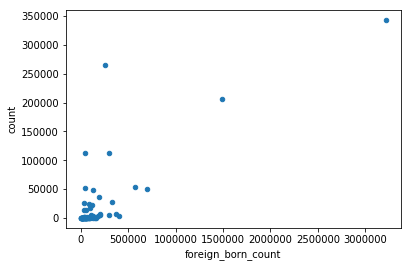

In [64]:
fb_count = df.plot.scatter(x='foreign_born_count',
                   y='count')

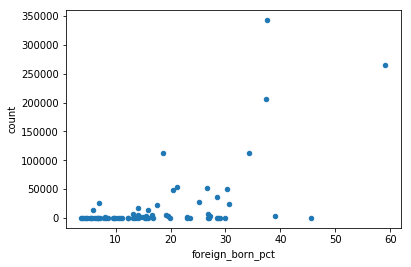

In [65]:
fb_pct = df.plot.scatter(x='foreign_born_pct',
                   y='count')

Looking at the graphs above, there appears to be a slight correlation, although the data is hardly conclusive.
Lets sort the data by the foreign_born_pct to see if we can gather any more insights.

In [66]:
df.sort_values('foreign_born_pct', ascending=False)

,city_name,state_code,foreign_born_count,foreign_born_pct,count
1,Miami,FL,260789,59.137303,265496
37,Santa Ana,CA,152999,45.613747,267
22,San Jose,CA,401493,39.096852,4245
0,New York,NY,3212500,37.571320,342609
2,Los Angeles,CA,1485425,37.398386,205618
3,San Francisco,CA,297199,34.365576,112967
12,Newark,NJ,86253,30.595609,24078
7,Houston,TX,696210,30.288067,49547
52,Providence,RI,53532,29.872101,12
36,Brownsville,TX,53301,28.985578,299


Looking at the data there does not seem to be a strong correlation. Although there are cities like New York, Miami and Los Angeles with a high foreign_born_pct, which also have a large amount of immigration, there are also many other cities such as Santa Ana, Providence and Brownsville with a high foreign_born_pct but low immigration. Morever, cities like Atlanta and Detroit have a very low foreign_born_pct yet high immigration.

Perahps a more likey reason for these cities that have higher levels of immigration (such as New York, Miami, Los Angeles, Atlanta and Detroit) are due to these cities being more major cities (i.e. more populous.)

Lets carry out some further analysis to see if this is correct:

In [70]:
df_pop = df_join.select('id',"city_name", df_fact_immigration["state_code"], 'total_pop')
     

In [71]:
df_pop.show(5)

+--------+-----------+----------+---------+
|      id|  city_name|state_code|total_pop|
+--------+-----------+----------+---------+
| 21853.0|   New York|        NY|  8550405|
|243533.0|Los Angeles|        CA|  3971896|
|445543.0|     Boston|        MA|   669469|
|450428.0|    Atlanta|        GA|   463875|
|629341.0|    Orlando|        FL|   270917|
+--------+-----------+----------+---------+
only showing top 5 rows



In [72]:
df_pop = df_pop.groupBy('city_name','state_code','total_pop').count()\
    .orderBy(desc('count'))

df_pop.show(7)

+---------------+----------+---------+------+
|      city_name|state_code|total_pop| count|
+---------------+----------+---------+------+
|       New York|        NY|  8550405|342609|
|          Miami|        FL|   440989|265496|
|    Los Angeles|        CA|  3971896|205618|
|  San Francisco|        CA|   864816|112967|
|        Orlando|        FL|   270917|112710|
|        Chicago|        IL|  2720556| 52888|
|Fort Lauderdale|        FL|   178587| 52774|
+---------------+----------+---------+------+
only showing top 7 rows



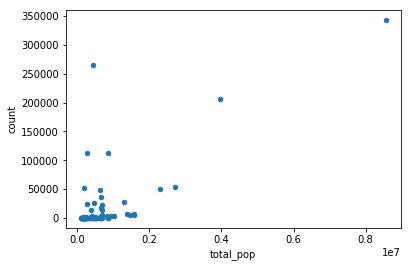

In [73]:
df_pop = df_pop.toPandas()

population_vs_immigration = df_pop.plot.scatter(x='total_pop',
                   y='count')

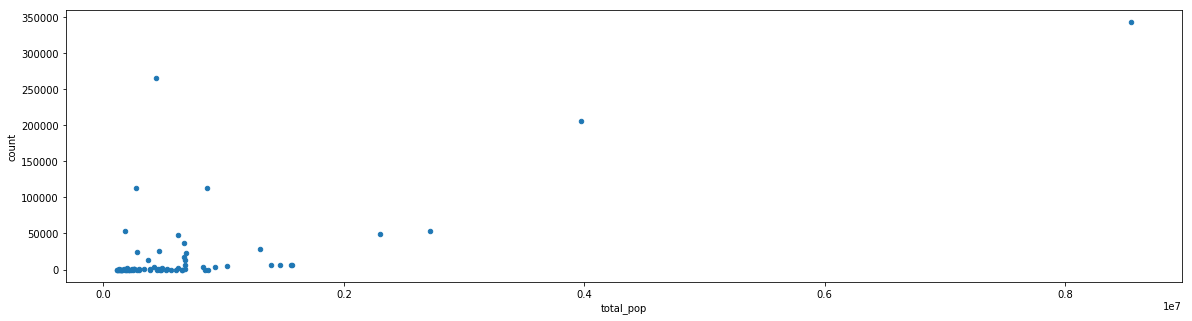

In [89]:
# lets make the scatter plot wider
plt.rcParams["figure.figsize"] = (20, 5)
df_pop.plot.scatter(x='total_pop',y='count');

In [74]:
df_pop.sort_values('total_pop', ascending=False)

,city_name,state_code,total_pop,count
0,New York,NY,8550405,342609
2,Los Angeles,CA,3971896,205618
5,Chicago,IL,2720556,52888
7,Houston,TX,2298628,49547
18,Philadelphia,PA,1567442,6408
20,Phoenix,AZ,1563001,5703
21,San Antonio,TX,1469824,5660
17,San Diego,CA,1394907,6987
10,Dallas,TX,1300082,28238
22,San Jose,CA,1026919,4245


Once again there appears to be a slight correlation, although the data is not very conclusive.
Further analysis will need to be carried out in order to draw stronger conclusions.